<a href="https://colab.research.google.com/github/palak-38/inter_iit_trials/blob/main/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.nn.functional import sigmoid
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, log_loss, precision_recall_curve
import numpy as np

# Load the image from a file or URL
image_path = "/kaggle/input/pictures/h1.jpg"
image = Image.open(image_path)

# Initialize processor and model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

# Exact artifact names from the uploaded file
clip_prompts_dict = {
    "Inconsistent object boundaries": "Objects with inconsistent or jagged edges.",
    "Discontinuous surfaces": "Surfaces with gaps or breaks.",
    "Non-manifold geometries in rigid structures": "Unrealistic overlapping in rigid structures.",
    "Floating or disconnected components": "Parts floating or detached from the object.",
    "Asymmetric features in naturally symmetric objects": "Asymmetry in normally symmetric objects.",
    "Misaligned bilateral elements in animal faces": "Misaligned facial features in animals.",
    "Irregular proportions in mechanical components": "Mechanical parts with odd proportions.",
    "Texture bleeding between adjacent regions": "Textures bleeding between regions.",
    "Texture repetition patterns": "Repeated or unnatural texture patterns.",
    "Over-smoothing of natural textures": "Overly smooth, unnatural surfaces.",
    "Artificial noise patterns in uniform surfaces": "Unnatural noise on uniform surfaces.",
    "Unrealistic specular highlights": "Highlights inconsistent with lighting.",
    "Inconsistent material properties": "Materials that look fake or inconsistent.",
    "Metallic surface artifacts": "Metal surfaces with distorted reflections.",
    "Dental anomalies in mammals": "Teeth in animals that look unnatural.",
    "Anatomically incorrect paw structures": "Paws with anatomically incorrect shapes.",
    "Improper fur direction flows": "Fur with unnatural direction or flow.",
    "Unrealistic eye reflections": "Unrealistic reflections in eyes.",
    "Misshapen ears or appendages": "Misshapen ears or appendages.",
    "Impossible mechanical connections": "Impossible or non-functional mechanical joints.",
    "Inconsistent scale of mechanical parts": "Inconsistent part sizes in objects.",
    "Physically impossible structural elements": "Structures that seem physically impossible.",
    "Inconsistent shadow directions": "Shadows misaligned with light direction.",
    "Multiple light source conflicts": "Conflicting shadows from multiple lights.",
    "Missing ambient occlusion": "Missing shadows or ambient occlusion.",
    "Incorrect reflection mapping": "Reflections that don’t match surroundings.",
    "Incorrect perspective rendering": "Distorted perspectives in objects.",
    "Scale inconsistencies within single objects": "Inconsistent scales within a single object.",
    "Spatial relationship errors": "Spatial errors in object arrangements.",
    "Depth perception anomalies": "Depth cues that don’t make sense.",
    "Over-sharpening artifacts": "Over-sharpened edges or halos.",
    "Aliasing along high-contrast edges": "Jagged edges on curves.",
    "Blurred boundaries in fine details": "Blurry fine details.",
    "Loss of fine detail in complex structures": "Loss of detail in complex areas.",
    "Artificial enhancement artifacts": "Unnatural or enhanced features.",
    "Incorrect wheel geometry": "Wheels or circles that look deformed.",
    "Implausible aerodynamic structures": "Aerodynamic shapes that don’t make sense.",
    "Misaligned body panels": "Misaligned parts or panels.",
    "Distorted window reflections": "Windows with distorted reflections.",
    "Anatomically impossible joint configurations": "Joints in animals that are impossible.",
    "Unnatural pose artifacts": "Poses that seem unnatural or forced.",
    "Biological asymmetry errors": "Biological asymmetry in living creatures.",
    "Regular grid-like artifacts in textures": "Grid-like patterns in textures.",
    "Repeated element patterns": "Repeating elements that look artificial.",
    "Systematic color distribution anomalies": "Unnatural or systematic color patterns.",
    "Color coherence breaks": "Color breaks or harsh transitions.",
    "Unnatural color transitions": "Lighting gradients that look fake.",
    "Resolution inconsistencies within regions": "Resolution differences in parts of the image.",
    "Unnatural Lighting Gradients": "Lighting gradients that look fake.",
    "Incorrect Skin Tones": "Skin tones that are unrealistic.",
    "Fake depth of field": "Exaggerated depth of field effects.",
    "Abruptly cut off objects": "Objects cut off abruptly.",
    "Glow or light bleed around object boundaries": "Glow or halos around edges.",
    "Ghosting effects: Semi-transparent duplicates of elements": "Ghosting or semi-transparent duplicates.",
    "Cinematization Effects": "Overly dramatic and unnatural lighting.",
    "Excessive sharpness in certain image regions": "Surfaces that are too glossy.",
    "Artificial smoothness": "Synthetic materials that look fake.",
    "Movie-poster like composition of ordinary scenes": "Inconsistent shadow sources.",
    "Dramatic lighting that defies natural physics": "Exaggerated features on objects or beings.",
    "Artificial depth of field in object presentation": "Unrealistic foreshortening in animals.",
    "Unnaturally glossy surfaces": "Same object types with different scales.",
}

# Preprocess the image
inputs = processor(text=list(clip_prompts_dict.values()), images=image, return_tensors="pt", padding=True)

# Get the model outputs
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # Image-text similarity scores

# Normalize logits before applying sigmoid
logits_min, logits_max = logits_per_image.min(), logits_per_image.max()
logits_scaled = (logits_per_image - logits_min) / (logits_max - logits_min + 1e-7)  # Normalize to [0, 1] range
logits_centered = (logits_scaled * 2) - 1  # Scale to [-1, 1] range for better sigmoid response

X_train, X_test, y_train, y_test = train_test_split(logits_centered, labels_matrix, test_size=0.2, random_state=42)

# Train and calibrate classifiers
calibrated_classifiers = []
for i in range(labels_matrix.shape[1]):  # For each artifact
    base_clf = SGDClassifier(loss="log", max_iter=1000, random_state=42)
    base_clf.fit(X_train, y_train[:, i])
    calibrated_clf = CalibratedClassifierCV(base_clf, method="sigmoid", cv="prefit")
    calibrated_clf.fit(X_train, y_train[:, i])
    calibrated_classifiers.append(calibrated_clf)

# Predict probabilities on test set
y_pred_probs = np.array([clf.predict_proba(X_test)[:, 1] for clf in calibrated_classifiers]).T
y_pred = (y_pred_probs > 0.5).astype(int)

# Evaluate model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Log loss evaluation
for i, artifact in enumerate(clip_prompts_dict.keys()):
    loss = log_loss(y_test[:, i], y_pred_probs[:, i])
    print(f"Log Loss for {artifact}: {loss:.4f}")

# Predict probabilities for new images
new_logits_matrix = np.load("new_logits_matrix.npy")
new_logits_scaled = (new_logits_matrix - logits_min) / (logits_max - logits_min + 1e-7)
new_logits_centered = (new_logits_scaled * 2) - 1

new_probs = np.array([clf.predict_proba(new_logits_centered)[:, 1] for clf in calibrated_classifiers]).T
for image_idx, probs in enumerate(new_probs):
    print(f"Artifact probabilities for new image {image_idx + 1}:")
    for artifact_idx, prob in enumerate(probs):
        print(f"  {list(clip_prompts_dict.keys())[artifact_idx]}: {prob:.2f}")

# # Apply sigmoid to scaled logits
# probs = sigmoid(logits_centered)

# # Get artifacts with probabilities > 0.5
# threshold = 0.5
# high_prob_indices = (probs > threshold).nonzero(as_tuple=True)[1]
# high_prob_artifacts = [list(clip_prompts_dict.keys())[i] for i in high_prob_indices]

# # Print results
# print("Artifacts with probabilities > 0.5:")
# for artifact, prob in zip(high_prob_artifacts, probs[0, high_prob_indices]):
#     print(f"{artifact} (Probability: {prob.item():.2f})")


Artifacts with probabilities > 0.5:
Non-manifold geometries in rigid structures (Probability: 0.55)
Misaligned bilateral elements in animal faces (Probability: 0.73)
Over-smoothing of natural textures (Probability: 0.56)
Metallic surface artifacts (Probability: 0.54)
Dental anomalies in mammals (Probability: 0.56)
Unrealistic eye reflections (Probability: 0.58)
Physically impossible structural elements (Probability: 0.57)
Inconsistent shadow directions (Probability: 0.55)
Missing ambient occlusion (Probability: 0.62)
Scale inconsistencies within single objects (Probability: 0.53)
Over-sharpening artifacts (Probability: 0.61)
Loss of fine detail in complex structures (Probability: 0.52)
Artificial enhancement artifacts (Probability: 0.58)
Incorrect wheel geometry (Probability: 0.53)
Implausible aerodynamic structures (Probability: 0.52)
Anatomically impossible joint configurations (Probability: 0.60)
Unnatural pose artifacts (Probability: 0.50)
Biological asymmetry errors (Probability: 

NameError: name 'clip_prompts' is not defined

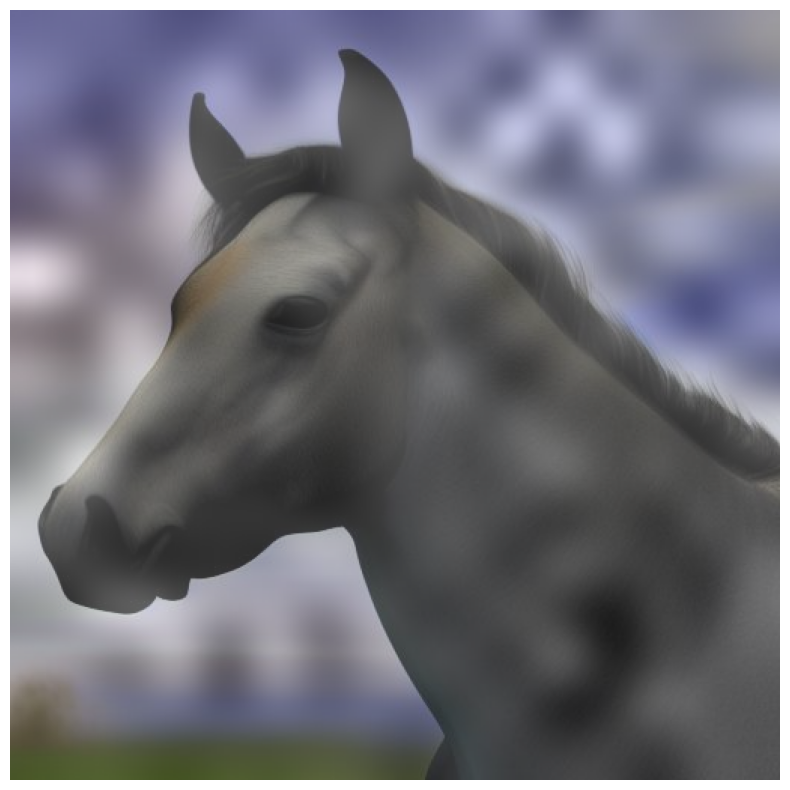

In [ ]:
import matplotlib.pyplot as plt
target_layer = model.vision_model.encoder.layers[-1]

# Hooks to capture gradients and activations
gradients = []
activations = []

def save_gradients_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def save_activations_hook(module, input, output):
    activations.append(output)

# Register hooks to the MLP layer of the target transformer layer
target_layer.mlp.fc2.register_forward_hook(save_activations_hook)
target_layer.mlp.fc2.register_full_backward_hook(save_gradients_hook)

# Forward pass
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # Image-text similarity scores

# Compute gradients for the first prompt
highest_prob_index = 0  # Index of the first prompt in clip_prompts
model.zero_grad()
logits_per_image[0, highest_prob_index].backward(retain_graph=True)

# Extract activations and gradients
activations = activations[0].detach()  # Feature maps
gradients = gradients[0].detach()  # Gradients of the feature maps

# Compute Grad-CAM weights
weights = torch.mean(gradients, dim=1, keepdim=True)  # Average gradients across tokens
cam = torch.sum(weights * activations, dim=-1).squeeze()  # Weighted sum over embedding dimensions

# Exclude the class token and reshape to spatial dimensions
num_patches = int(cam.shape[-1] ** 0.5)  # Assuming a square grid of patches
cam = cam[1:].reshape(num_patches, num_patches)  # Exclude the class token and reshape

# Normalize the heatmap
cam = torch.nn.functional.relu(cam)  # Remove negative values
cam = cam - cam.min()
cam = cam / cam.max()

# Resize heatmap to match the image size
heatmap = cam.cpu().numpy()
heatmap = np.uint8(255 * heatmap)  # Convert to 0-255 range
heatmap_resized = Image.fromarray(heatmap).resize(image.size, Image.LANCZOS).convert("RGB")

# Overlay heatmap on the image
heatmap_overlay = Image.blend(image, heatmap_resized, alpha=0.5)

# Display the result using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(heatmap_overlay)
plt.axis("off")
plt.title(f"Grad-CAM for: {clip_prompts[highest_prob_index]}")
plt.show()

# Save the heatmap overlay
heatmap_overlay.save("gradcam_overlay.jpg")
print("Grad-CAM overlay saved as gradcam_overlay.jpg")

In [ ]:
import clip
import torch
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix
import numpy as np

# Load CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", device="cuda")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Example dataset (images and artifact labels)
# X_images: List of image file paths
# y_labels: Binary matrix of shape (num_images, num_artifacts) (1: artifact present, 0: absent)
X_images = ["image1.jpg", "image2.jpg", "image3.jpg"] #more images
y_labels = csr_matrix((len(X_images),len(artifact_texts)))
artifact_texts = list(clip_prompts_dict.keys())

# Precompute artifact text embeddings
text_tokens = clip.tokenize(artifact_texts).to(device)
text_features = model.encode_text(text_tokens)
text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize text embeddings

# Compute image embeddings and similarities
def compute_similarities(image_paths,batch_size=32):
    similarities = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = torch.stack([preprocess(Image.open(p)).to(device) for p in batch_paths])
        with torch.no_grad():
            image_features = model.encode_image(batch_images)
            image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize image embeddings
            batch_similarities = image_features @ text_features.T
            similarities.extend(batch_similarities.cpu().numpy())
    return np.array(similarities)

# Compute features (cosine similarities) for all images
X_features = compute_similarities_batched(X_images,batch_size=64)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)

# Training model with sgd for scalability
sgd_model = SGDClassifier(loss="log", max_iter=1000)
for i in range(0, X_train.shape[0], 64):  # Process in batches
    batch_features = X_train[i:i + 64]
    batch_labels = y_train[i:i + 64].toarray()  # Convert sparse batch to dense
    sgd_model.partial_fit(batch_features, batch_labels, classes=np.unique(y_labels.toarray()))

# Predict on Test Set
y_pred = sgd_model.predict(X_test)
y_prob = sgd_model.predict_proba(X_test)  # Probabilities for each artifact

# Print Classification Report
print("Classification Report:")
print(classification_report(y_test.toarray(), y_pred))

# Example: Predict probabilities for new image
new_images = ["new_image.jpg"]
new_features = compute_similarities(new_images,batch_size=1)
new_probs = sgd_model.predict_proba(new_features)

# Display artifact probabilities for the new image
for i, artifact in enumerate(artifact_texts):
    print(f"Probability of '{artifact}': {new_probs[0][i]:.4f}")
